In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.ndimage import rotate, shift
from sklearn.model_selection import train_test_split

In [2]:
import torchxrayvision as xrv
d = xrv.datasets.COVID19_Dataset(imgpath="data/images/", csvpath="data/csv/metadata.csv")

C:\Users\Hoo Kai Sng\OneDrive - National University of Singapore\Documents\NUS\CS3244\Project\xrayenv\Lib\site-packages\torchxrayvision\utils.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [11]:
def generate_new_image(img):

    if random.random() > 0.5:
        img = np.fliplr(img)

    angle = random.uniform(-10, 10)
    img = rotate(img, angle, reshape=False)

    max_shift_x = int(0.1 * img.shape[1])
    max_shift_y = int(0.1 * img.shape[0])
    shift_x = random.randint(-max_shift_x, max_shift_x)
    shift_y = random.randint(-max_shift_y, max_shift_y)
    img = shift(img, shift=(shift_y, shift_x), mode='reflect')
    return img

def get_data(neg_idx, pos_idx, data, random_state, resample = False):
    res, n_pos, n_neg = [], 0, 0
    random.seed(random_state)
    for i in neg_idx:
        img, lab = data[i]['img'][0], data[i]['lab'][3]
        res.append({'img': img, 'lab': lab})
        n_neg += 1
    for i in pos_idx:
        img, lab = data[i]['img'][0], data[i]['lab'][3]
        res.append({'img': img, 'lab': lab})
        n_pos += 1
    if resample:
        while n_neg < n_pos:
            i = random.choice(neg_idx)
            img, lab = data[i]['img'][0], data[i]['lab'][3]
            res.append({'img': generate_new_image(img), 'lab': lab})
            n_neg += 1
    return res

def stratified_split(dataset, random_state = 44):
    n = len(dataset)
    neg = [i for i, x in enumerate(dataset) if x['lab'][3] == 0]
    pos = [i for i, x in enumerate(dataset) if x['lab'][3] == 1]

    train_neg, temp_neg = train_test_split(neg, train_size = 0.7, random_state = random_state)
    val_neg, test_neg = train_test_split(temp_neg, train_size = 0.5, random_state = random_state)
    train_pos, temp_pos = train_test_split(pos, train_size = 0.7, random_state = random_state)
    val_pos, test_pos = train_test_split(temp_pos, train_size = 0.5, random_state = random_state)

    train = get_data(train_neg, train_pos, dataset, random_state, resample = True)
    val = get_data(val_neg, val_pos, dataset, random_state)
    test = get_data(test_neg, test_pos, dataset, random_state)

    return train, val, test



In [12]:
train, val, test = stratified_split(d)

In [13]:
def explore_data(data, processed):
    n = len(data)
    p, f = 0, 0
    for i in range(n):
        if processed:
            lab = data[i]['lab']
        else:
            lab = data[i]['lab'][3]

        if lab == 1:
            p += 1
        else:
            f += 1
    print(f"Data Size: {n} | Postives: {p} | Negatives: {f}") 

In [14]:
explore_data(train, True)
explore_data(val, True)
explore_data(test, True)

Data Size: 478 | Postives: 239 | Negatives: 239
Data Size: 80 | Postives: 51 | Negatives: 29
Data Size: 81 | Postives: 52 | Negatives: 29


In [23]:
import torch
import torchvision.transforms as transforms
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image

class Covid19DataSet(Dataset):

    def __init__(self, d, transform = 'vanilla', random_state = 44):
        data_transforms = {
            'augment': transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomHorizontalFlip(p=0.3),
            transforms.ToTensor(),
            ]),
            'vanilla': transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            ]),
        }
        
        high, low = get_images_max_min(d)
        self.data = d
        self.high = high
        self.low = low
        self.transform = data_transforms[transform]

    def __getitem__(self, index):

        img = self.data[index]['img']
        img = Image.fromarray(normalize(img, self.high, self.low))

        if self.transform:
            img_tensor = self.transform(img)

        label = self.data[index]['lab']
        label_tensor = torch.tensor([label], dtype = torch.float)
        
        return img_tensor, label_tensor

    def __len__(self):
        return len(self.data)

def get_images_max_min(data):
    high = low = 0.0
    for i in range(len(data)):
        img = data[i]['img']
        ch = np.max(img)
        cl = np.min(img)    
    high = max(high, ch)
    low = min(low, cl)
    return high, low    

def normalize(img, high, low):
    return np.divide(img - low, high - low)

In [24]:
abc = Covid19DataSet(train)
abc_loader = DataLoader(dataset = abc, batch_size = 1, shuffle = True, num_workers = 0)

In [25]:
gen = iter(abc_loader)
img_sam, label_sam = next(gen)

<class 'torch.Tensor'>


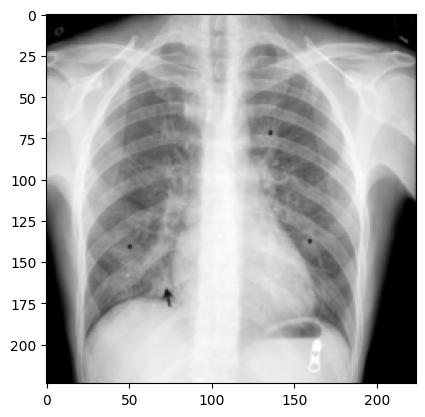

In [30]:
import matplotlib.pyplot as plt
print(type(img_sam))
plt.imshow(img_sam.squeeze(0).squeeze(0).numpy(), cmap = 'gray')